### Importing the libraries

In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.metrics import confusion_matrix, classification_report

In [7]:
tf.__version__

'2.18.0'

### Data Preprocessing

In [11]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
training_set = train_datagen.flow_from_directory('C:\\Users\\User\\Downloads\\Brain tumor MRI\\Training',
                                                 target_size=(299, 299),
                                                 batch_size=32,
                                                 class_mode='categorical')

Found 5712 images belonging to 4 classes.


In [13]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory('C:\\Users\\User\\Downloads\\Brain tumor MRI\\Testing',
                                            target_size=(299, 299),
                                            batch_size=32,
                                            class_mode='categorical',
                                            shuffle=False)

Found 1311 images belonging to 4 classes.


In [15]:
from sklearn.model_selection import train_test_split

all_image_paths = training_set.filepaths

train_paths, test_paths, train_index, test_index = train_test_split(
    all_image_paths, range(len(all_image_paths)), test_size=0.2, random_state=42
)

### Data Visualization

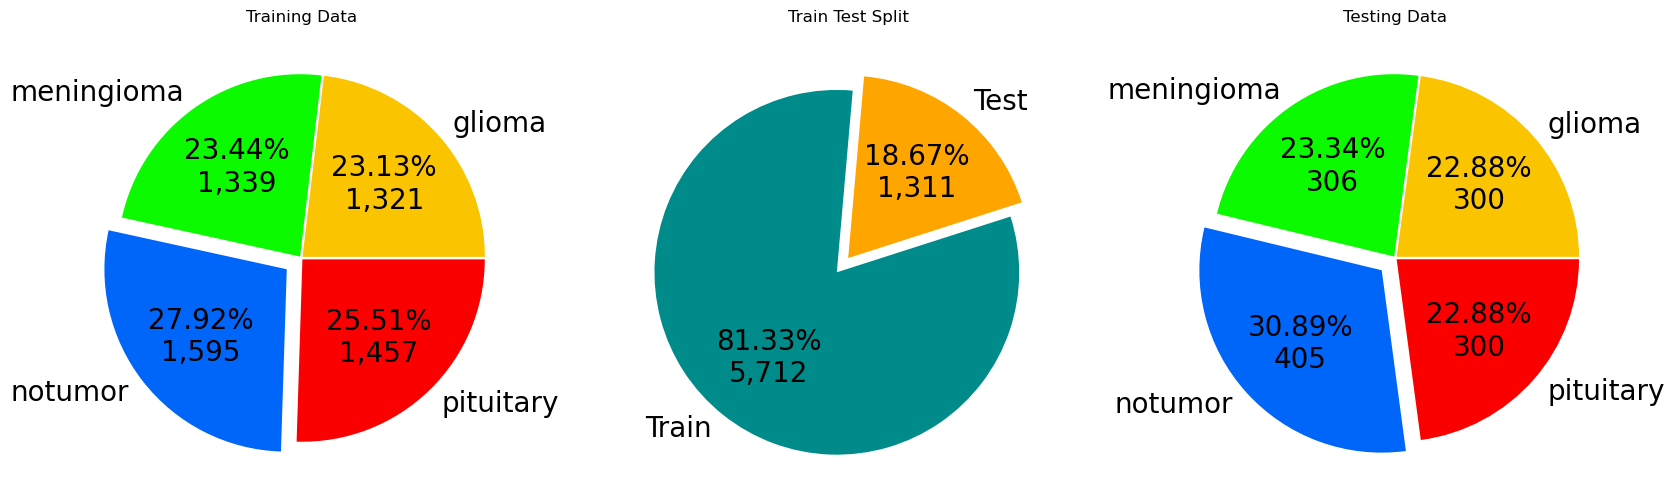

In [18]:
class_names = list(training_set.class_indices.keys())
class_counts_train = list(training_set.classes)
class_counts_test = list(test_set.classes)
train_counts = [class_counts_train.count(i) for i in range(len(class_names))]
test_counts = [class_counts_test.count(i) for i in range(len(class_names))]
fig, ax = plt.subplots(ncols=3, figsize=(20, 14))

ax[0].set_title('Training Data')
ax[0].pie(
    train_counts,
    labels=class_names,
    colors=['#FAC500', '#0BFA00', '#0066FA', '#FA0000'],
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(train_counts) / 100),
    explode=(0.01, 0.01, 0.1, 0.01),
    textprops={'fontsize': 20}
)

ax[1].set_title('Train Test Split')
ax[1].pie(
    [len(training_set.labels), len(test_set.labels)],
    labels=['Train', 'Test'],
    colors=['darkcyan', 'orange'],
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum([len(training_set.labels), len(test_set.labels)]) / 100),
    explode=(0.1, 0),
    startangle=85,
    textprops={'fontsize': 20}
)

ax[2].set_title('Testing Data')
ax[2].pie(
    test_counts,
    labels=class_names,
    colors=['#FAC500', '#0BFA00', '#0066FA', '#FA0000'],
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(test_counts) / 100),
    explode=(0.01, 0.01, 0.1, 0.01),
    textprops={'fontsize': 20}
)

plt.show()


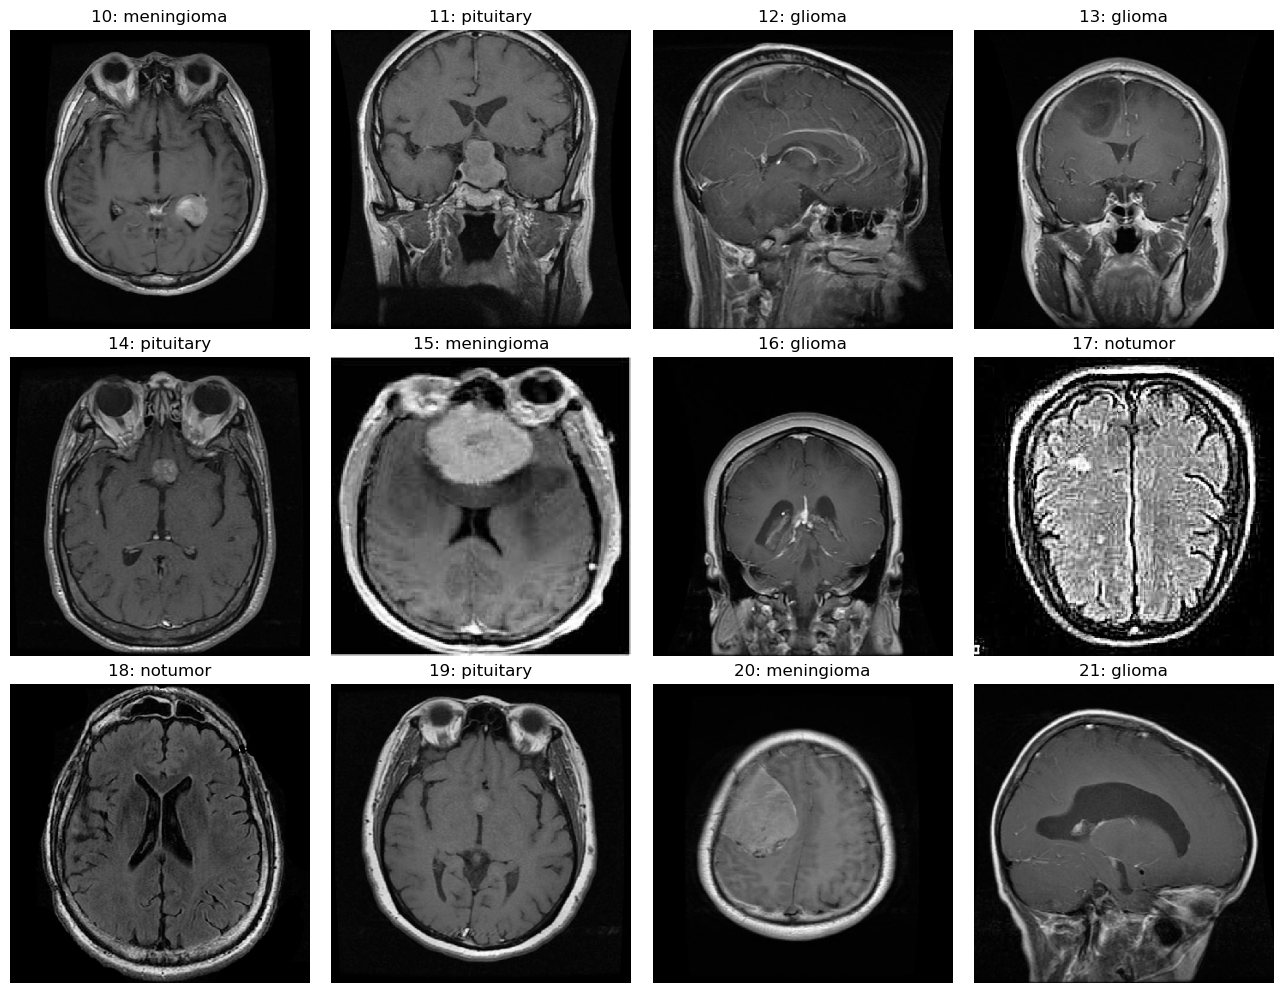

In [20]:
all_image_paths = training_set.filepaths
all_labels = training_set.labels  

train_paths, test_paths, train_labels, test_labels = train_test_split(
    all_image_paths, all_labels, test_size=0.2, random_state=42
)

class_mappings = training_set.class_indices  

def show_images(paths, labels, class_mappings, index_list=range(10), im_size=250, figsize=(12, 8)):
    num_images = len(index_list)
    num_rows = (num_images + 3) // 4
    index_to_class = {v: k for k, v in class_mappings.items()}  
    _, ax = plt.subplots(nrows=num_rows, ncols=4, figsize=figsize)
    ax = ax.flatten()

    for i, index in enumerate(index_list):
        if i >= num_images:
            break
        image = load_img(paths[index], target_size=(im_size, im_size), color_mode='grayscale')
        ax[i].imshow(image, cmap='Greys_r')
        class_name = index_to_class[labels[index]]  
        ax[i].set_title(f'{index}: {class_name}')
        ax[i].axis('off')

    plt.tight_layout()
    plt.show()

show_images(train_paths, train_labels, class_mappings, im_size=350, figsize=(13,10),
            index_list=range(10, 22))

### Training Setup

### Building the CNN

In [28]:
cnn = models.Sequential()
cnn.add(layers.Conv2D(filters=64, kernel_size=3, activation='relu', input_shape=[299, 299, 3]))
cnn.add(layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(layers.Conv2D(filters=128, kernel_size=3, activation='relu'))  # Increased filters
cnn.add(layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(layers.Conv2D(filters=256, kernel_size=3, activation='relu'))  # Increased filters
cnn.add(layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(units=256, activation='relu'))
cnn.add(layers.Dense(units=128, activation='relu'))
cnn.add(layers.Dense(units=64, activation='relu'))
cnn.add(layers.Dense(units=4, activation='softmax'))

cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = cnn.fit(x=training_set, validation_data=test_set, epochs=100)

C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\User\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.4617 - loss: 1.3781 - val_accuracy: 0.6270 - val_loss: 1.0612
Epoch 2/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 163s 909ms/step - accuracy: 0.6692 - loss: 0.7883 - val_accuracy: 0.7323 - val_loss: 0.6788
Epoch 3/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 163s 907ms/step - accuracy: 0.7287 - loss: 0.6866 - val_accuracy: 0.6789 - val_loss: 0.8413
Epoch 4/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 163s 909ms/step - accuracy: 0.7467 - loss: 0.6524 - val_accuracy: 0.7361 - val_loss: 0.7201
Epoch 5/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 164s 917ms/step - accuracy: 0.7450 - loss: 0.6300 - val_accuracy: 0.7696 - val_loss: 0.6418
Epoch 6/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 164s 916ms/step - accuracy: 0.7810 - loss: 0.5674 - val_accuracy: 0.7857 - val_loss: 0.5628
Epoch 7/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 164s 915ms/step - accuracy: 0.7869 - loss: 0.5383 - val_accuracy: 0.7651 - val_loss: 0.6371
Epoch 8/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 164s 912ms/step - accuracy: 0.8

### Plotting the Graphs of Accuracy and Loss

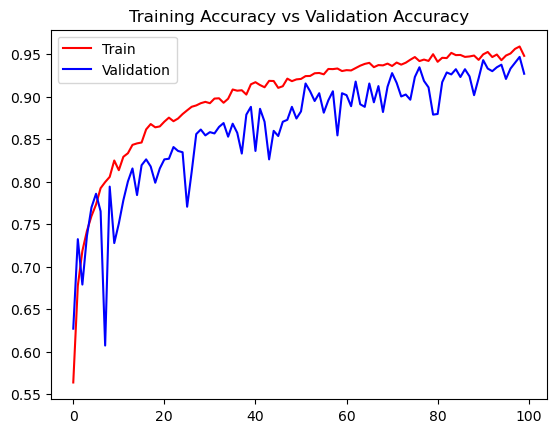

In [31]:
plt.title('Training Accuracy vs Validation Accuracy')

plt.plot(history.history['accuracy'], color='red',label='Train')
plt.plot(history.history['val_accuracy'], color='blue',label='Validation')

plt.legend()

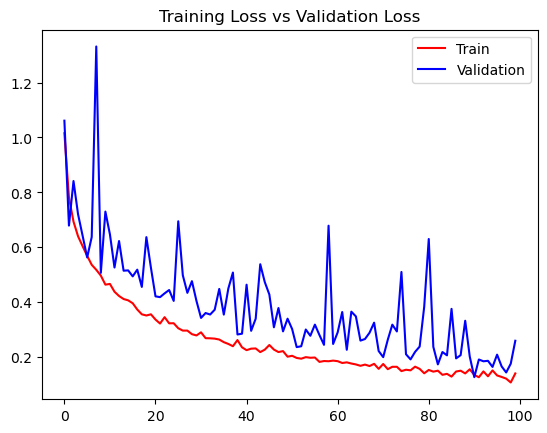

In [33]:
plt.title('Training Loss vs Validation Loss')

plt.plot(history.history['loss'], color='red',label='Train')
plt.plot(history.history['val_loss'], color='blue',label='Validation')

plt.legend()

### EVALUATING THE MODEL

41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 182ms/step


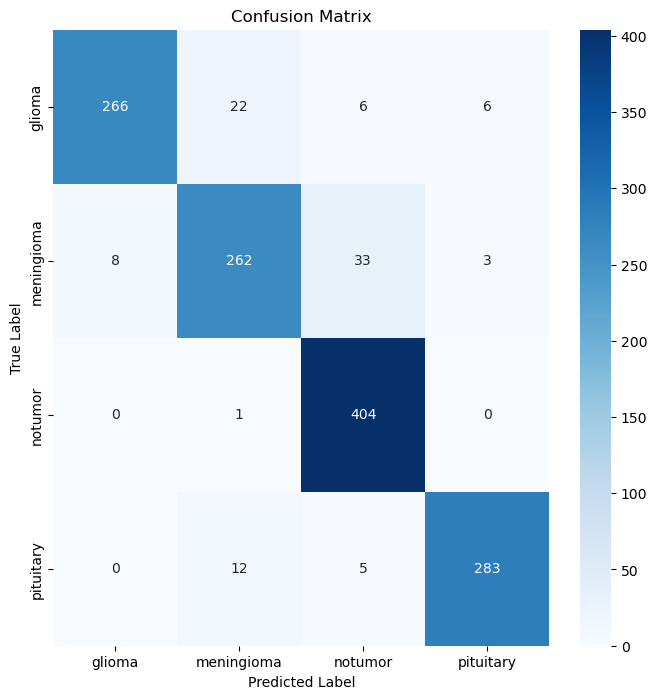

              precision    recall  f1-score   support

      glioma       0.97      0.89      0.93       300
  meningioma       0.88      0.86      0.87       306
     notumor       0.90      1.00      0.95       405
   pituitary       0.97      0.94      0.96       300

    accuracy                           0.93      1311
   macro avg       0.93      0.92      0.92      1311
weighted avg       0.93      0.93      0.93      1311



In [36]:
y_predict = cnn.predict(test_set)

y_predict = np.argmax(y_predict, axis=1)

y_true = test_set.classes 

class_labels = list(test_set.class_indices.keys())

cm = confusion_matrix(y_true, y_predict)


plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_predict, target_names=class_labels))

### Plottinng samples with predictions

In [157]:
class_indices = training_set.class_indices  
inv_class_mappings = {v: k for k, v in class_indices.items()}  

def plot_sample_predictions(model, dataset, index_to_class, num_samples=9, figsize=(13, 12)):
    plt.figure(figsize=figsize)
    num_rows = num_cols = int(np.sqrt(num_samples))
    
    iterator = iter(dataset)

    for i in range(1, num_samples + 1):
        images, labels = next(iterator)
        
        image = images[0]
        true_label = labels[0]
        
        image_batch = tf.expand_dims(image, 0) 
        predictions = model.predict(image_batch, verbose=False)
        predicted_label = np.argmax(predictions, axis=1)[0]

        true_class_index = np.argmax(true_label)  
        true_class = index_to_class[true_class_index]
        predicted_class = index_to_class[predicted_label]

        title_color = 'green' if true_class_index == predicted_label else 'red'

        plt.subplot(num_rows, num_cols, i)
        plt.imshow(image.squeeze(), cmap='gray')  
        plt.title(f"True: {true_class}\nPred: {predicted_class}", color=title_color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

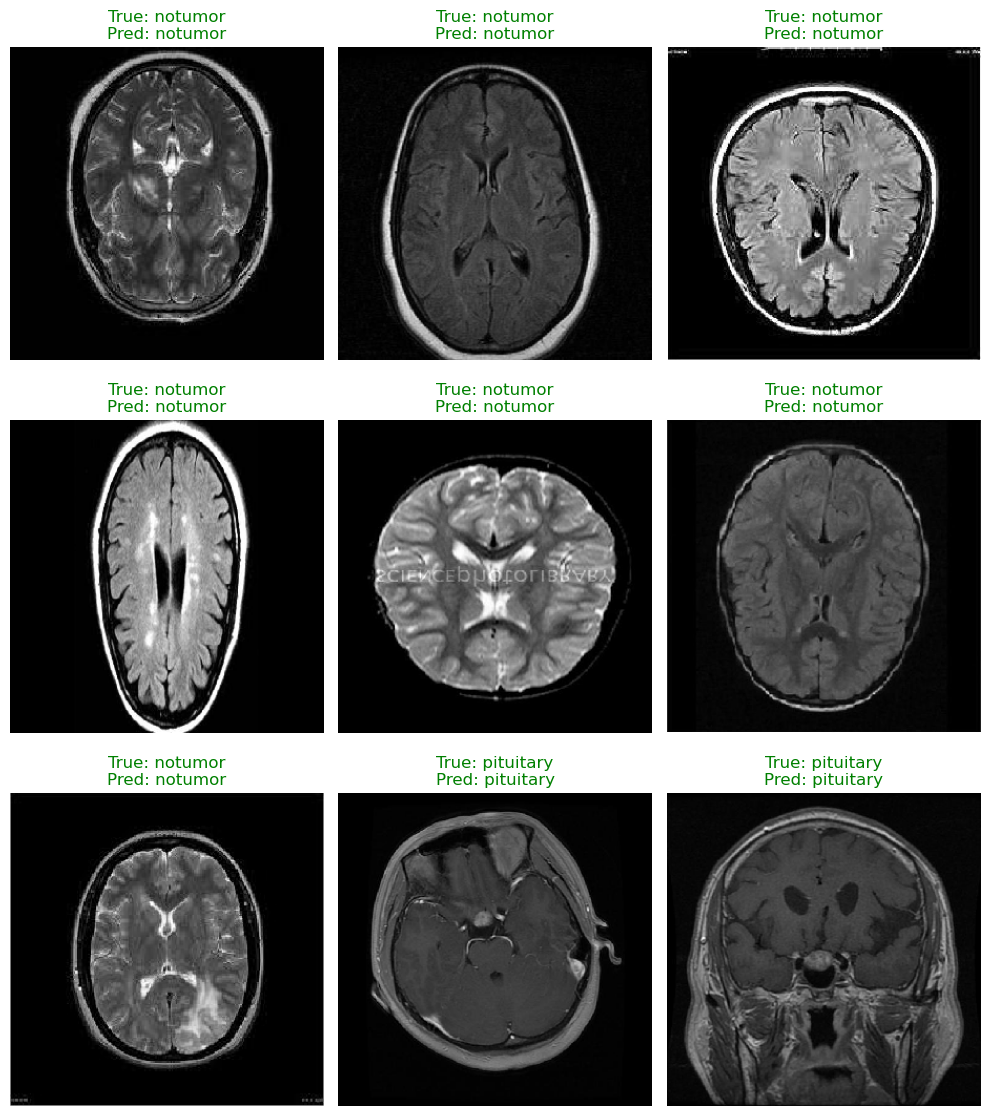

In [167]:
plot_sample_predictions(model=cnn,
                        dataset=test_set,  
                        index_to_class=inv_class_mappings,  
                        num_samples=9,
                        figsize=(10, 11.5))

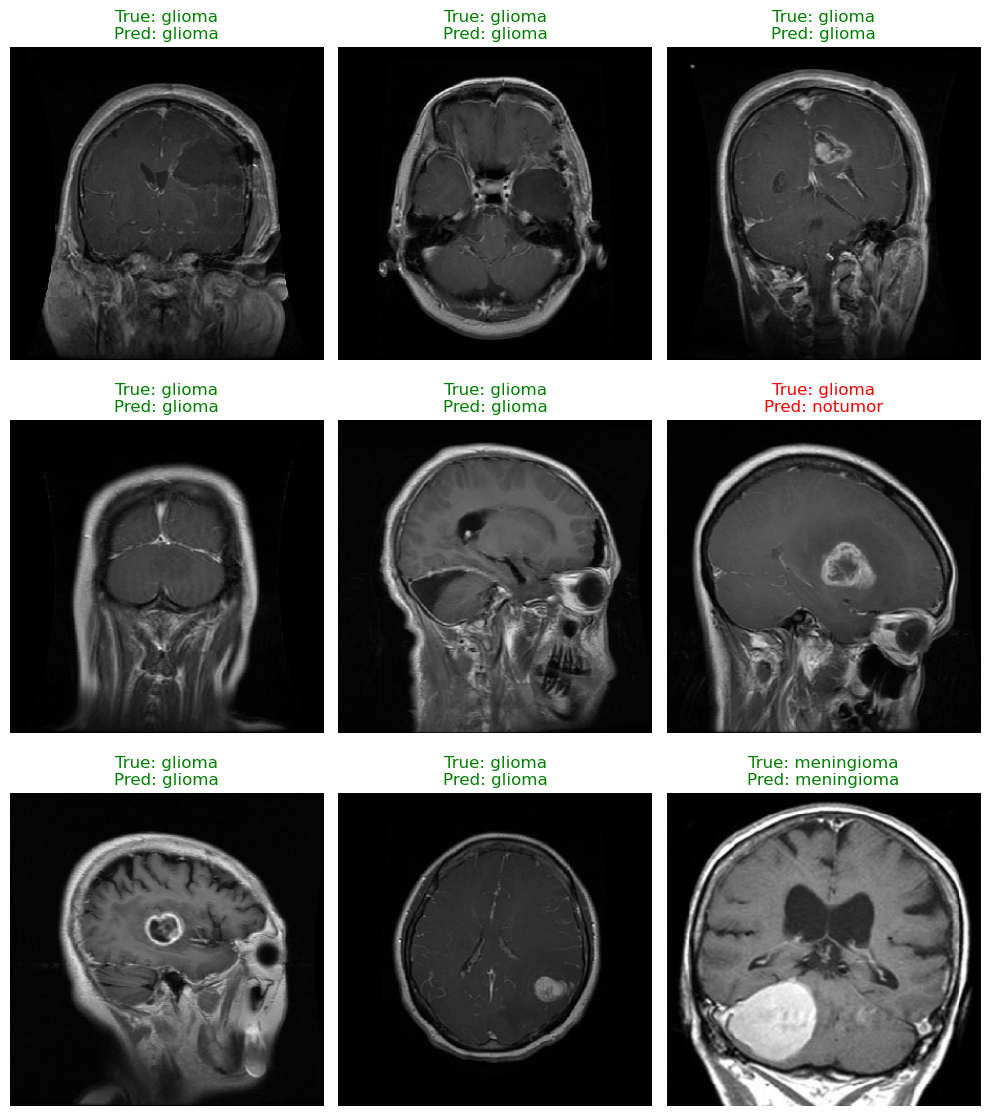

In [171]:
plot_sample_predictions(model=cnn,
                        dataset=test_set,  
                        index_to_class=inv_class_mappings,  
                        num_samples=9,
                        figsize=(10, 11.5))